In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle
import itertools
import random
import os
from src.encoders_decoders import *
from src.losses import *
from src.useful_functions import *
from torch.utils.data import DataLoader
from scipy.optimize import curve_fit
from lmfit import Model
from KDEpy import NaiveKDE
plt.rcParams['mathtext.fontset'] ='cm'
plt.rc('font',family= 'sans-serif', size=22)          # controls default text sizes
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
# Example of notebook for analyses

In [3]:
#Set working directory
datadir = os.getcwd() + "/data/Example"
plotsdir = os.getcwd()+"/Plots/"
files = os.listdir(datadir)
if not os.path.isdir(plotsdir):
    os.makedirs(plotsdir)

In [4]:
#Set paramrs of the stimulus distribution, number of neurons
N = 12
data = torch.load(os.path.join(datadir,files[0]))
p_x = torch.distributions.log_normal.LogNormal(1,1)
x_i =  p_x.sample((10000,))[:,None]
x_test_,_ = (p_x.sample((10000,))[:,None]).sort(dim=0)
x_min,x_max = x_test_[0,:].item(),x_test_[-1,:].item()
x_fine = torch.linspace(x_min,x_max,10000)[:,None]
H_p = p_x.entropy().item()

In [5]:
# Import encoder and decoder and compute relevant measures
s_min= float('+inf')
s_max= float('-inf')
A_min = float('+inf')
A_max = float('-inf')
enc = BernoulliEncoder(N,0,1,x_i,w=2) 
dec = MLPDecoder(N,100)
q_ = rate_ising(N)
#q_ = rate_bernoulli(N)
RVec,DVec,mseVec,HqVec,log_sigmas,centers,gains,HpVec,HpxVec,DpqVec,msevsx,mseVec2 = ([] for _ in range(12))
#for f in files[2:3]:
#data = torch.load(os.path.join(datadir,f))
with torch.no_grad():
    for i in range(len(data)):
        resume = data[i]
        R_vec = resume.keys()
        Rs,Ds,bs,mse,H_q,ls,cs,As,Hps,Hpxs,Dpqs,msexs,mse2 = ([] for _ in range(13))
        for R in R_vec:
            if  not np.isnan(resume[R]['history']['loss'][-1]):
                history_temp = resume[R]['history']
                #Losses and beta
                Ds.append(history_temp["distortion"][-1])
                Rs.append(history_temp["rate"][-1])
                bs.append(history_temp["beta"][-1])
                #Load encoding parameters
                enc.load_state_dict(resume[R]['encode'])
                dummy,indices = torch.sort(torch.squeeze(enc.cs))
                cs.append(dummy.numpy())
                ls.append(torch.squeeze(enc.log_sigmas).numpy()[indices])
                As.append(torch.squeeze(enc.As).numpy()[indices])
                #Load decoding parameters
                dec.load_state_dict(resume[R]['decoder'])
                #Load prior parameters
                q_.load_state_dict(resume[R]['q'])
                #Set maximum sigmas and amplitudes (for plotting)
                s_s = torch.min(enc.log_sigmas).item()
                s_l = torch.max(enc.log_sigmas).item()
                s_min = s_s if  s_s < s_min else s_min
                s_max = s_l if  s_l > s_max else s_max
                A_s = torch.min(enc.As).item()
                A_l = torch.max(enc.As).item()
                A_min = A_s if  A_s < A_min else A_min
                A_max = A_l if  A_l > A_max else A_max
                #For each activity pattern, compute mu_dec and sigma_dec
                mu_dec_all,log_sigma_all = dec(q_.r_all.transpose(0,1)[:,None,:])
                #Probability of activity patterns according to encoding distribution
                #Ising
                q_r = torch.softmax(q_.h@q_.r_all + 
                    (q_.r_all*(q_.J@q_.r_all)).sum(dim=0),1)
                #Bernoulli
                #q_r = torch.softmax(q_.h@q_.r_all ,1)
                wq = torch.distributions.Categorical(q_r)
                #Generative distribution as Mixture of Gaussians
                gsq = torch.distributions.normal.Normal(mu_dec_all,torch.exp(log_sigma_all))
                q_x = torch.distributions.mixture_same_family.MixtureSameFamily(wq,gsq)
                #Log probability of spiking
                eta = enc(x_test_)
                #Compute error vs stimuli in two ways: mean of the posterior(msex) vs sampling from posterior(msex2)
                p_r_x = torch.exp((eta@q_.r_all) - (torch.log( 1 + torch.exp(eta))).sum(dim=1)[:,None])
                msex = (((mu_dec_all[None,:]-x_test_)**2)*p_r_x).sum(dim=1).numpy()
                msex2 = (((mu_dec_all[None,:]-x_test_)**2 +  torch.exp(2*log_sigma_all[None,:]))*p_r_x).sum(dim=1).numpy()
                #Compute KL divergence between generative model and stimulus probability
                Dpqs.append(kl_divergence(p_x.log_prob(x_test_),q_x.log_prob(x_test_)))
                #Entropy of the prior
                H_q.append(- torch.sum(q_r*torch.log(q_r + 1e-10)).item())
                #Mean Squared Error
                mse.append(msex.mean())
                mse2.append(msex2.mean())
                #decidee whether to use sampling or psoterior in the analysis of error vs x
                msexs.append(msex2)
                #Compute mutual information from the entropy of the marginal - entropy of the conditional
                Hp,Hpx = mutual_information2(enc,q_,x_test_)
                Hps.append(Hp)
                Hpxs.append(Hpx)
            else:
                print("NaN")
                cs.append(np.full([N], np.nan))
                ls.append(np.full([N], np.nan))
                As.append(np.full([N], np.nan))
                Dpqs.append(np.nan)
                H_q.append(np.nan)
                mse.append(np.nan)
                mse2.append(np.nan)
                msexs.append(np.full([10000], np.nan))
                Ds.append(np.nan)
                Rs.append(np.nan)
                bs.append(np.nan)
                Hps.append(np.nan)
                Hpxs.append(np.nan)
            
        log_sigmas.append(ls)
        centers.append(cs)
        gains.append(As)
        RVec.append(Rs)
        DVec.append(Ds)
        mseVec.append(mse)
        HqVec.append(H_q)
        HpVec.append(Hps)
        HpxVec.append(Hpxs)
        DpqVec.append(Dpqs)
        msevsx.append(msexs)
        mseVec2.append(mse2)

NaN
NaN


In [6]:
# Transform lists in arrays
RVec = np.array(RVec)
DVec = np.array(DVec)
mseVec = np.array(mseVec)
mseVec2 = np.array(mseVec2)
HqVec = np.array(HqVec)
log_sigmas = np.array(log_sigmas)
centers = np.array(centers)
gains = np.array(gains)
DpqVec = np.array(DpqVec)
HpVec = np.array(HpVec)
HpxVec = np.array(HpxVec)
IVec = HpVec-HpxVec

<ErrorbarContainer object of 3 artists>

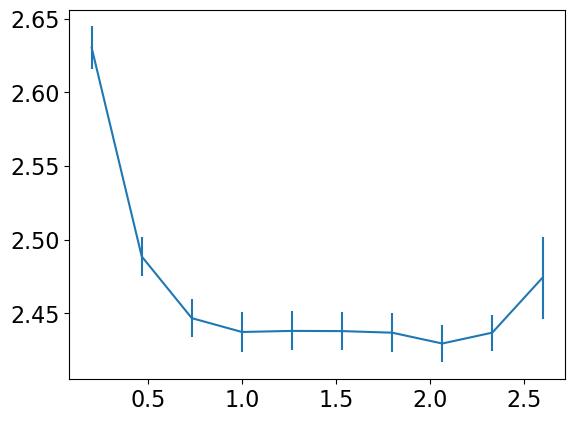

In [7]:
#Plot ELBO loss function
plt.errorbar(np.nanmean(RVec,0),np.nanmean(np.array(DVec) + np.array(RVec),0),yerr=np.nanstd(np.array(DVec) + np.array(RVec),0))

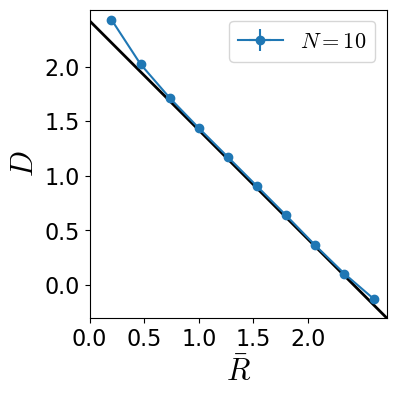

In [8]:
# Distortion Rate curve
fig,axs = plt.subplots(figsize=(4,4))
axs.plot( np.linspace(0,H_p+0.5),H_p - np.linspace(0,H_p+0.5),linewidth=2,color='black')
axs.errorbar(np.nanmean(RVec,0),np.nanmean(DVec,0),yerr = np.nanstd(DVec,0),xerr=np.nanstd(RVec,0),label=r'$N=10$',marker='o')
axs.set(xlabel=r"$\bar{R}$",ylabel= r"$D$",xticks= np.arange(0,H_p,step=0.5),
    yticks=np.arange(0,H_p,step=0.5),aspect='equal',xlim=[0,H_p+0.3],ylim=[-0.3,H_p+0.1]);
axs.legend()
#fig.savefig(plotsdir + '/DvsR_degeneracy_N10.svg')

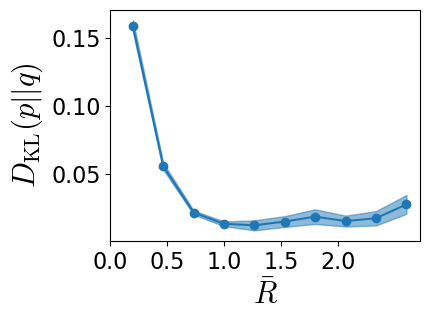

In [9]:
# Kullback Leibler diveregence (Evidence + Stimulus entropy)
fig,axs = plt.subplots(figsize=(4,3))
axs.plot(np.nanmean(RVec,0),np.nanmean(DpqVec,0),'-o',color='tab:blue')
axs.fill_between(np.nanmean(RVec,0),np.nanmean(DpqVec,0)-np.nanstd(DpqVec,0),
    np.nanmean(DpqVec,0)+np.nanstd(DpqVec,0),alpha=0.5,color='tab:blue')
axs.set(xlabel=r"$\bar{R}$",xticks=np.arange(0,H_p,step=0.5),
    ylabel=r"$D_{\mathrm{KL}}(p||q)$");
#fig.savefig(plotsdir + '/DklpqvsR.svg')

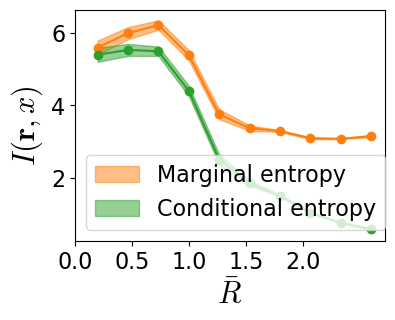

In [10]:
fig,axs = plt.subplots(figsize=(4,3))
axs.plot(np.nanmean(RVec,0),np.nanmean(HpVec,0),'-o',color='tab:orange')
axs.fill_between(np.nanmean(RVec,0),np.nanmean(HpVec,0)-np.nanstd(HpVec,0)/2,
    np.nanmean(HpVec,0)+np.nanstd(HpVec,0)/2,alpha=0.5,color='tab:orange',label= 'Marginal entropy')
axs.plot(np.nanmean(RVec,0),np.nanmean(HpxVec,0),'-o',color='tab:green')
axs.fill_between(np.nanmean(RVec,0),np.nanmean(HpxVec,0)-np.nanstd(HpxVec,0)/2,
    np.nanmean(HpxVec,0)+np.nanstd(HpxVec,0)/2,alpha=0.5,color='tab:green',label=r'Conditional entropy')
axs.set(xlabel=r"$\bar{R}$",ylabel= r"$I(\mathbf{r},x)$",xticks= np.arange(0,H_p,step=0.5),);
axs.legend()

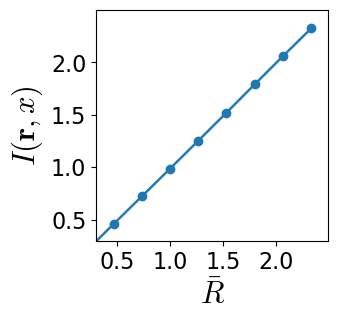

In [11]:
# Mutual information
fig,axs = plt.subplots(figsize=(3,3))
axs.plot(np.nanmean(RVec,0)[:-1],np.nanmean(IVec,0)[:-1],'-o',color='tab:blue')
axs.fill_between(np.nanmean(RVec,0)[:-1],np.nanmean(IVec,0)[:-1]-np.nanstd(IVec,0)[:-1]/2,
    np.nanmean(IVec,0)[:-1]+np.nanstd(IVec,0)[:-1]/2,alpha=0.5,color='tab:blue')
axs.set(xlabel=r"$\bar{R}$",ylabel= r"$I(\mathbf{r},x)$",xticks= np.arange(0.5,H_p,step=0.5),
    yticks=np.arange(0,H_p,step=0.5),xlim=(0.3,2.5),ylim=(0.3,2.5));
#fig.savefig(plotsdir + '/MIvsR.svg')

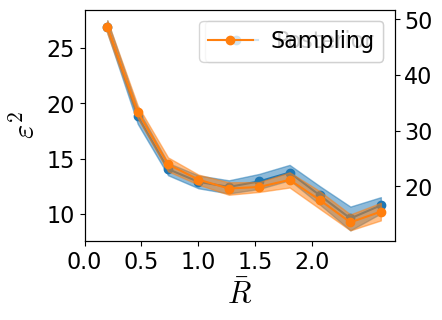

In [12]:
# Plot mean squared error (according to different definitions)
fig,axs = plt.subplots(figsize=(4,3))
axs.plot(np.nanmean(RVec,0),np.nanmean(mseVec,0),'-o',color='tab:blue',label=r'Posterior')
axs.fill_between(np.nanmean(RVec,0),np.nanmean(mseVec,0)-np.nanstd(mseVec,0),
    np.nanmean(mseVec,0)+np.nanstd(mseVec,0),alpha=0.5,color='tab:blue')
axs2=axs.twinx()
axs2.plot(np.nanmean(RVec,0),np.nanmean(mseVec2,0),'-o',color='tab:orange',label=r'Sampling')
axs2.fill_between(np.nanmean(RVec,0),np.nanmean(mseVec2,0)-np.nanstd(mseVec2,0),
    np.nanmean(mseVec2,0)+np.nanstd(mseVec2,0),alpha=0.5,color='tab:orange')
axs.set(xlabel=r"$\bar{R}$",
    ylabel=r"$\varepsilon^2$",xticks= np.arange(0,H_p,step=0.5))#,ylim=[0,35]
axs.legend()
axs2.legend()
#fig.savefig(plotsdir + '/EmeanvsR.svg')


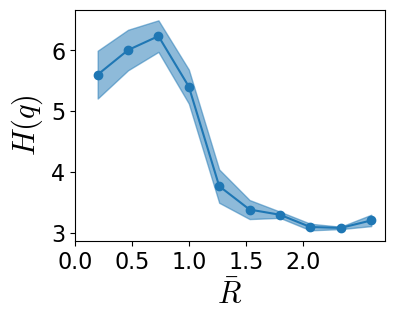

In [13]:
#Plot prior entropy
fig,axs = plt.subplots(figsize=(4,3))
axs.plot(np.nanmean(RVec,0),np.nanmean(HqVec,0),'-o',color='tab:blue')
axs.fill_between(np.nanmean(RVec,0),np.nanmean(HqVec,0)-np.nanstd(HqVec,0),
    np.nanmean(HqVec,0)+np.nanstd(HqVec,0),alpha=0.5,color='tab:blue')
axs.set(xlabel=r"$\bar{R}$",xticks=np.arange(0,H_p,step=0.5),
    ylabel=r"$H(q)$");
#fig.savefig(plotsdir + '/HqvsR.svg')

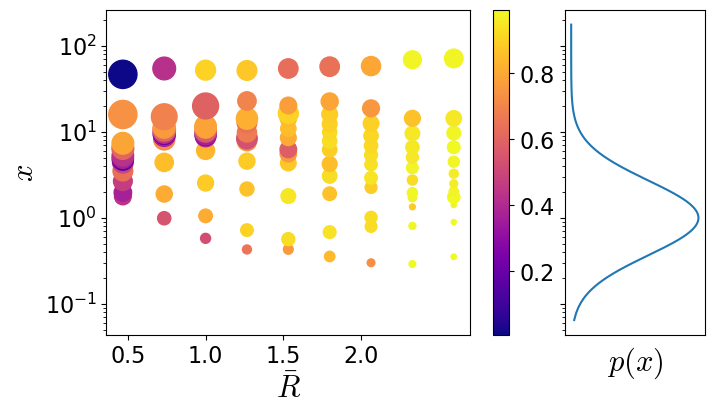

In [14]:
# Plot encoder tuning curves
fig = plt.figure(figsize=(7,5))
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005
rect_scatter = [left, bottom, width, height]
rect_histy = [left + width + spacing, bottom, 0.2, height]
ax = fig.add_axes(rect_scatter)
f = lambda x: x/(1+x)
C_min = np.min(np.vstack([f(np.nanmean(gains,0)[i,:]) for i,R in enumerate(list(R_vec)[1:])]))
C_max = np.max(np.vstack([f(np.nanmean(gains,0)[i,:]) for i,R in enumerate(list(R_vec)[1:])]))
for i,R in enumerate(list(R_vec)[1:]):
    if R < 2.9:
        ax.scatter([R]*N,np.nanmean(centers,0)[i,:],s = 45*(np.nanmean(log_sigmas,0)[i,:]-s_min),
                c= f(np.nanmean(gains,0)[i,:]),vmin=C_min,vmax=C_max,cmap='plasma')
        #ax.set_yscale("log")
ax.set(xlabel=r"$\bar{R}$",ylabel=r"$x$",xticks=np.arange(0.5,H_p,step=0.5))
ax=plt.gca() #get the current axes
PCM=ax.get_children()[2]
plt.colorbar(PCM,location='right')
ax2 = fig.add_axes(rect_histy,sharey=ax)
ax2.plot(torch.exp(p_x.log_prob(x_test_)),x_test_)
ax.set_yscale("log")
ax2.set(xticks=[],xlabel=r"$p(x)$")
plt.setp(ax2.get_yticklabels(), visible=False);
#fig.savefig(plotsdir + '/colorbar.svg')

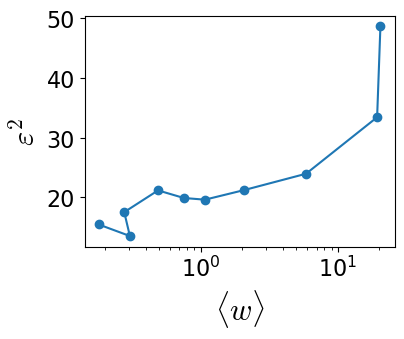

In [16]:
# Plot error vs tuning width
sigmasw = torch.exp(p_x.log_prob(torch.from_numpy(np.where(~np.isnan(centers),centers,1)))).numpy()
S = np.sum(sigmasw,2)[:,:,None]
w_mean= np.sum((np.exp(log_sigmas)*sigmasw/S),2)
#Plot MSE vs average width
fig,axs = plt.subplots(figsize=(4,3))
axs.plot(np.nanmean(w_mean,0),np.nanmean(mseVec2,0),'-o',color='tab:blue',label=r'Posterior')
#axs2=axs.twinx()
#axs2.plot(np.nanmean(w_mean,0),np.nanmean(mseVec2,0),'-o',color='tab:orange',label=r'Sampling')
axs.set(xlabel=r"$\langle w\rangle$",ylabel= r"$\varepsilon^2$",xscale="log");
#fig.savefig(plotsdir + '/emeanvsmeanwidth.svg')

1.0
0.976606289196124
1.8
0.4771168221262868
2.6
0.4616450169614596


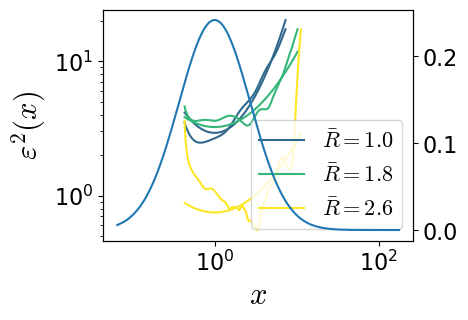

In [17]:
# Analyzed dependence of coding precision and tuning curves parameters as a function of stimulus distribution.
# Fit with functional form A/p(x)^gamma
# Extract number of rates and number of simulations
nR = len(data[0].keys())
ntrials = len(data)
#USeful functions
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
def pred_mse(px,logA,gamma):
    return logA - gamma*(px)
colors= plt.cm.viridis(np.linspace(0,1,len(msevsx[0])))
AVec,gammaVec,Asd,gammasd,R2 =([] for _ in range(5))
fig,axs = plt.subplots(figsize=(4,3))
#Compute error as a function of x averaged over different trials
msemean = [np.nanmean(np.array([msevsx[n][i] for n in range(ntrials)]),axis=0) for i in range(nR)]
#Define which rates to analyze
R_analysis = [3,6,9]
for i in R_analysis:
    Rm = list(R_vec)[i]
    print(Rm)
    #Smooth of MSE as a function of x by calculating moving average
    xfilt= moving_average(x_test_[:,0],w=700)
    msema = moving_average(msemean[i],w=700)
    #Keep only points where the mean squared error is less than C variance of the stimulus (coding 'make sense').
    #Pay attention that, depending on C, at low rates yopu may find point which never satsify the condition
    if i == 5:
        mask = msema<0.5*p_x.variance.item()
    else:
        mask = msema<0.5*p_x.variance.item()
    #Define data for fitting e(x) 
    xdata = torch.squeeze(p_x.log_prob(torch.from_numpy(xfilt[mask]))).numpy()
    ydata = msema[mask]
    #Fit and save fitting parameters
    pfit,pcov = curve_fit(pred_mse, xdata, np.log(ydata), p0=[-1,1])
    AVec.append(pfit[0])
    gammaVec.append(pfit[1])
    print(pfit[1])
    Asd.append(pcov[0,0])
    gammasd.append(pcov[1,1])
    Rss = np.sum((np.log(ydata)-pred_mse(xdata,*pfit))**2)
    Tss = np.sum((np.log(ydata) - np.nanmean(np.log(ydata)))**2)
    R2.append(1-Rss/Tss)
    #Plot fitting results
    axs.plot(xfilt[mask],np.exp(pred_mse(xdata,*pfit)),color=colors[i],label=r"$\bar R={:.1f}$".format(Rm))
    axs.plot(xfilt[mask],ydata,color=colors[i])
    #axs.scatter(np.exp(xdata),np.log(ydata),color=colors[i])
    #axs.plot(np.exp(xdata),pred_mse(xdata,*pfit),label=r"$R={:.1f}$".format(Rm),color=colors[i])
    #print(R2)
axs.set(xscale="log",yscale="log",xlabel=r"$x$",ylabel=r"$\varepsilon^2(x)$")
axs.legend()
axs2 = axs.twinx()
axs2.plot(x_test_,torch.exp(p_x.log_prob(x_test_)))
#fig.savefig(plotsdir + '/msevsprior_pre_fit.svg')

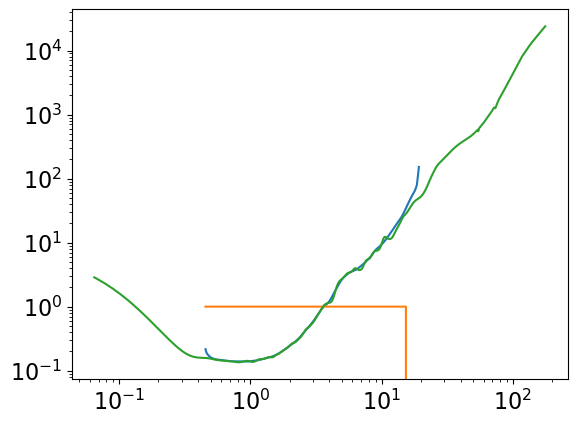

In [18]:
i=8
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
mask = msemean[i]<0.5*p_x.variance.item()
plt.plot(moving_average(x_test_[:,0],w=800),moving_average(msemean[i],w=800))
plt.plot(moving_average(x_test_[:,0],w=800),moving_average(msemean[i],w=800)<p_x.variance.item())
plt.plot(x_test_,msemean[i])
plt.yscale("log")
plt.xscale("log")

In [20]:
#Concatenate all values of tuning width and centers
log_sigmas_all = [np.concatenate([log_sigmas[i,n,:][~ np.isnan(log_sigmas[i,n,:])] 
    for i in range(ntrials)]) for n in range(nR)]
centers_all = [np.concatenate([centers[i,n,:][~ np.isnan(centers[i,n,:])] 
    for i in range(ntrials)]) for n in range(nR)]

1.0
1.8
2.6


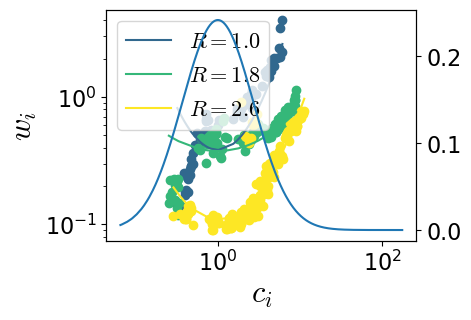

In [21]:
# Tuning width as a function of stimulus probability
def pred_width(px,A,gamma):
    return A/(px)**gamma
def pred_width2(px,logA,gamma):
    return logA-gamma*px
AVec,gammaVec,Asd,gammasd,R2 =([] for _ in range(5))
fig,axs = plt.subplots(figsize=(4,3))
colors= plt.cm.viridis(np.linspace(0,1,len(msevsx[0])))
for i in R_analysis:
    Rm = list(R_vec)[i]
    print(Rm)
    v,idx = torch.sort(torch.tensor(centers_all[i]))
    emask = msemean[i]<0.4*p_x.variance.item()
    cmask = emask[np.digitize(v,x_test_[:,0])-1]
    csort = v[cmask]
    #xdata = torch.exp(p_x.log_prob(torch.abs(v))).numpy()
    xdata = p_x.log_prob(torch.abs(csort)).numpy()
    ydata = torch.tensor(log_sigmas_all[i][idx][cmask]).numpy()
    #plt.plot(xdata,pred_width(xdata,0.1,0.01,0.7))
    pfit,pcov = curve_fit(pred_width2, xdata, ydata, p0=[-1,1])
    AVec.append(pfit[0])
    gammaVec.append(pfit[1])
    Asd.append(pcov[0,0])
    gammasd.append(pcov[1,1])
    Rss = np.sum((ydata - pred_width2(xdata,*pfit))**2)
    Tss = np.sum((ydata - np.nanmean(ydata))**2)
    R2.append(1-Rss/Tss)
    #axs.scatter(np.exp(xdata),np.exp(ydata),color=colors[i])
    #axs.plot(np.exp(xdata),np.exp(pred_width2(xdata,*pfit)),label=r"$R={:.1f}$".format(Rm),color=colors[i])
    axs.scatter(csort,np.exp(ydata),color=colors[i])
    axs.plot(csort,np.exp(pred_width2(xdata,*pfit)),color=colors[i],label=r"$R={:.1f}$".format(Rm))
axs.set(xscale="log",yscale="log",xlabel=r"$c_i$",ylabel=r"$w_i$")
axs.legend()
axs2 = axs.twinx()
axs2.plot(x_test_,torch.exp(p_x.log_prob(x_test_)))
fig.savefig(plotsdir + '/widthvsprior_pre_fit2.svg')
    

3
6
9


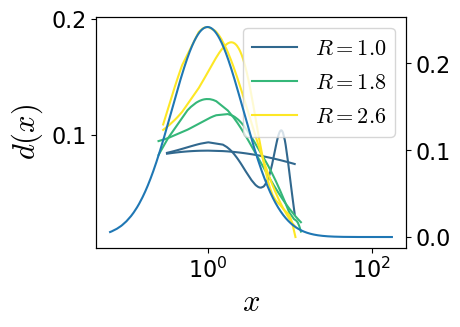

In [23]:
# Neural density as a function of stimulus probability
def pred_density(px,logA,gamma):
    return logA+gamma*px
AVec,gammaVec,Asd,gammasd,R2 =([] for _ in range(5))
colors= plt.cm.viridis(np.linspace(0,1,len(msevsx[0])))
fig,axs = plt.subplots(figsize=(4,3))
for i in R_analysis:#range(len(log_sigmas_all)):
    #v,idx = torch.sort(torch.tensor(c_1[i]))
    print(i)
    Rm = list(R_vec)[i]
    #els,bins = np.histogram(centers_all[i],np.logspace(0.001,np.log10(max(centers_all[i])),15),density=1)
    #xdata = p_x.log_prob(torch.from_numpy(bins[:-1][els>0])).numpy()
    csort = np.sort(centers_all[i])
    emask = msemean[i]<p_x.variance.item()
    cmask = emask[np.digitize(csort,x_test_[:,0])-1]
    csort = csort[cmask]
    #Neural density is estimated through a kernel density estimator
    y = NaiveKDE(bw='silverman').fit(csort).evaluate(csort)
    ydata = np.log(y)
    xdata = p_x.log_prob(torch.from_numpy(csort)).numpy()
    #plt.plot(xdata,pred_width(xdata,0.1,0.01,0.7))
    pfit,pcov = curve_fit(pred_density, xdata, ydata, p0=[-1,1.])
    AVec.append(pfit[0])
    gammaVec.append(pfit[1])
    Asd.append(pcov[0,0])
    gammasd.append(pcov[1,1])
    Rss = np.sum((ydata - pred_density(xdata,*pfit))**2)
    Tss = np.sum((ydata - np.nanmean(ydata))**2)
    R2.append(1-Rss/Tss)
    #print(R2)
    #axs.scatter(np.exp(xdata),np.exp(ydata),color=colors[i])
    #axs.plot(np.exp(xdata),np.exp(pred_density(xdata,*pfit)),color=colors[i],label=r"$R={:.1f}$".format(Rm))
    axs.plot(csort,y,color=colors[i],label=r"$R={:.1f}$".format(Rm))
    axs.plot(csort,np.exp(pred_density(xdata,*pfit)),color=colors[i])
axs.set(xscale="log",xlabel=r"$x$",ylabel = r"$d(x)$",yticks=[0.1,0.2])
axs.legend()
axs2 = axs.twinx()
axs2.plot(x_test_,torch.exp(p_x.log_prob(x_test_)))
fig.savefig(plotsdir + '/densityvsprior_fit_withfit.svg')



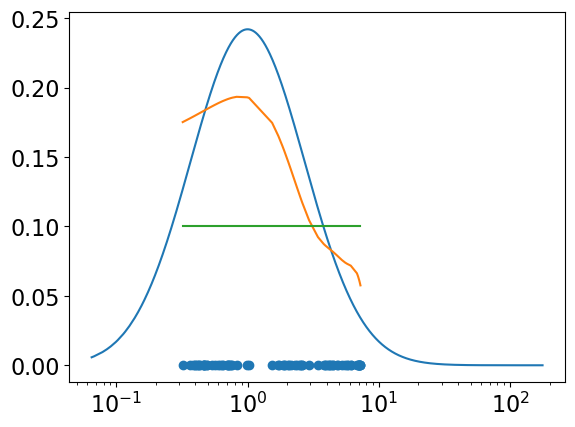

In [24]:
i=3
csort = np.sort(centers_all[i])
emask = msemean[i]<0.5*p_x.variance.item()
cmask = emask[np.digitize(csort,x_test_[:,0])-1]
csort = csort[cmask]
plt.scatter(csort,0*np.ones(csort.shape[0]))
plt.xscale("log")
plt.plot(x_test_,torch.exp(p_x.log_prob(x_test_)))
y = NaiveKDE(bw='silverman').fit(csort).evaluate(csort)
plt.plot(csort,y)
#plt.yscale("log")
plt.xscale("log")
mask = msemean[i]<p_x.variance.item()
plt.plot(csort,0.1*mask[np.digitize(csort,x_test_[:,0])])

-0.753491133057666
-0.7724556741104908
-0.7194657954777471


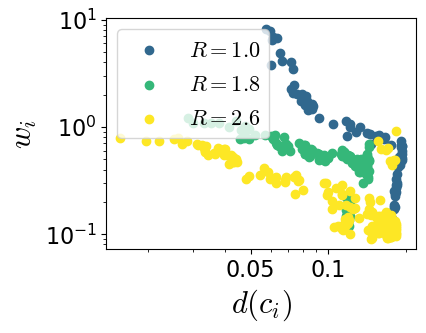

In [25]:
#Plot d vs w
AVec,gammaVec,Asd,gammasd,R2 =([] for _ in range(5))
colors= plt.cm.viridis(np.linspace(0,1,len(msevsx[0])))
fig,axs = plt.subplots(figsize=(4,3))
for i in R_analysis:#range(len(log_sigmas_all)):
    #v,idx = torch.sort(torch.tensor(c_1[i]))
    Rm = list(R_vec)[i]
    v,idx = torch.sort(torch.tensor(centers_all[i]))
    emask = msemean[i]<0.5*p_x.variance.item()
    cmask = emask[np.digitize(v,x_test_[:,0])-1]
    csort = v[cmask].numpy()
    y = NaiveKDE(bw='silverman').fit(csort).evaluate(csort)
    xdata = np.exp(torch.tensor(log_sigmas_all[i][idx][cmask]).numpy())
    axs.scatter(y,xdata,color=colors[i],label=r"$R={:.1f}$".format(Rm))
    print(np.corrcoef(y,xdata)[0,1])
axs.set(xlabel=r"$d(c_i)$",ylabel = r"$w_i$",yscale="log",xscale="log",xticks=[0.05,0.1],xticklabels=[0.05,0.1])
axs.legend()
#fig.savefig(plotsdir + '/densityvsw.svg')

-0.0639681384577987
-0.9571545259199018
-0.7471300675885033


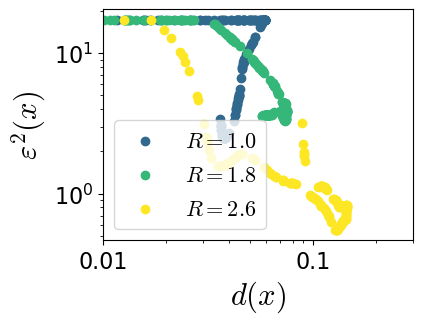

In [26]:
#Plot d/w vs error
colors= plt.cm.viridis(np.linspace(0,1,len(msevsx[0])))
fig,axs = plt.subplots(figsize=(4,3))
for i in R_analysis:#range(len(log_sigmas_all)):
    #v,idx = torch.sort(torch.tensor(c_1[i]))
    Rm = list(R_vec)[i]
    xfilt= moving_average(x_test_[:,0],w=700)
    msema = moving_average(msemean[i],w=700)
    v,idx = torch.sort(torch.tensor(centers_all[i]))
    emask = msema<0.5*p_x.variance.item()
    cmask = emask[np.digitize(v,xfilt[emask])-1]
    csort = v[cmask].numpy()
    #xdata = np.exp(torch.tensor(log_sigmas_all[i][idx][cmask]).numpy())
    xdata = NaiveKDE(bw='silverman').fit(csort).evaluate(csort)
    ydata = msema[np.digitize(csort,xfilt[emask])]
    axs.scatter(xdata,ydata,color=colors[i],
        label=r"$R={:.1f}$".format(Rm))
    print(np.corrcoef(xdata,ydata)[0,1])
axs.set(xscale="log",xlabel=r"$d(x)$",yscale="log",ylabel = r"$\varepsilon^2(x)$",xlim=[0.01,0.3],xticks=[0.01,0.1],xticklabels=[0.01,0.1])
axs.legend()
fig.savefig(plotsdir + '/dvse.svg')

0.6198933031255788
0.5787294909041001
0.8425433068833748


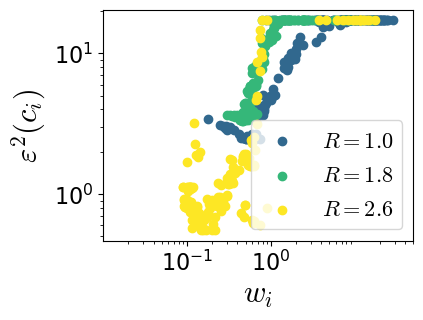

In [27]:
# Plot w vs error
colors= plt.cm.viridis(np.linspace(0,1,len(msevsx[0])))
fig,axs = plt.subplots(figsize=(4,3))
for i in R_analysis:#range(len(log_sigmas_all)):
    #v,idx = torch.sort(torch.tensor(c_1[i]))
    Rm = list(R_vec)[i]
    xfilt= moving_average(x_test_[:,0],w=700)
    msema = moving_average(msemean[i],w=700)
    v,idx = torch.sort(torch.tensor(centers_all[i]))
    emask = msema<0.5*p_x.variance.item()
    cmask = emask[np.digitize(v,xfilt[emask])-1]
    csort = v[cmask].numpy()
    xdata = np.exp(torch.tensor(log_sigmas_all[i][idx][cmask]).numpy())
    #xdata = NaiveKDE(bw='silverman').fit(csort).evaluate(csort)
    ydata = msema[np.digitize(csort,xfilt[emask])]
    axs.scatter(xdata,ydata,color=colors[i],
        label=r"$R={:.1f}$".format(Rm))
    print(np.corrcoef(xdata,ydata)[0,1])
axs.set(xscale="log",xlabel=r"$w_i$",yscale="log",ylabel = r"$\varepsilon^2(c_i)$",xlim=[0.01,50],xticks=[0.1,1])
axs.legend()
fig.savefig(plotsdir + '/dvse.svg')